# Epoch averaged microstate analysis


In [1]:
# Library import
import mne
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')


## Data loader

# Single epcoh based codebase

In [2]:
# Load the EEG data from the provided EDF file
eeg_data = mne.io.read_raw_edf("data/data_Subject01_2_10.edf", preload=True)
eeg_data.info


Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject01_2_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, F7, F8, T7, T8, C3, C4, P7, P8, P3, P4, O1, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2020-10-05 18:33:44 UTC
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (3.302 sec)



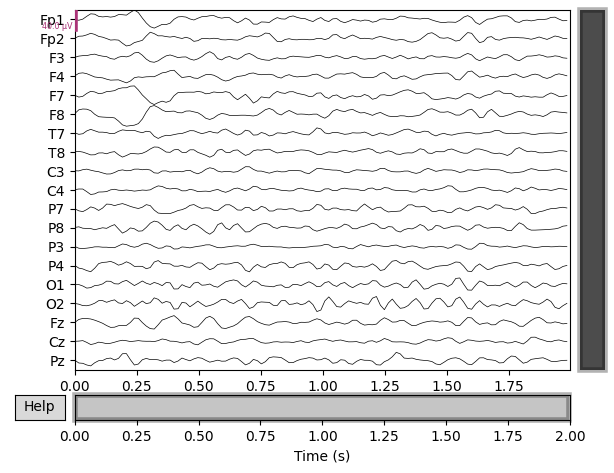

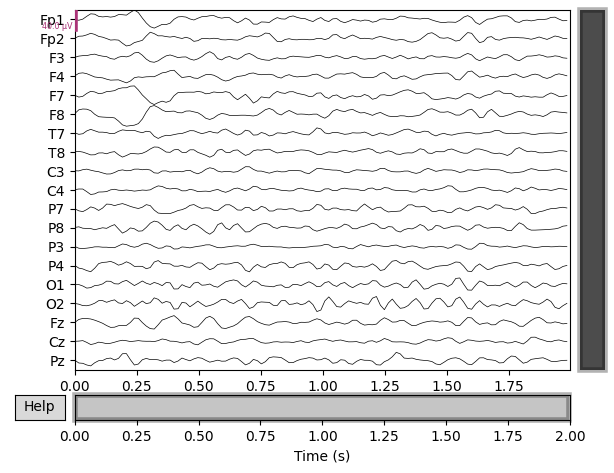

In [3]:
# Apply bandpass filter to retain frequencies between 1 and 20 Hz
eeg_data_filtered = eeg_data.copy().filter(l_freq=1, h_freq=20)

eeg_data_filtered.plot(duration=2, n_channels=19)


# Segmentation

This is typically done by identifying the time points with peak global field power (GFP) since these are moments of highest "synchrony" in the EEG data. At each of these peak GFP time points, the scalp topography is treated as a potential microstate.

In [4]:
# Calculate the Global Field Power (GFP) for the EEG data
gfp = np.std(eeg_data_filtered._data, axis=0)

# Identify the time points with peak GFP
peak_indices = (gfp[:-2] < gfp[1:-1]) & (gfp[1:-1] > gfp[2:])

# Extract the time points of these peaks
peak_times = eeg_data_filtered.times[1:-1][peak_indices]

# Extract the topographies at these peak time points
peak_topographies = eeg_data_filtered._data[:, 1:-1][:, peak_indices]

peak_times, peak_topographies.shape

(array([0.064, 0.14 , 0.202, 0.24 , 0.322, 0.376, 0.404, 0.44 , 0.488,
        0.546, 0.606, 0.652, 0.698, 0.78 , 0.832, 0.872, 0.91 , 0.942,
        0.982, 1.018, 1.052, 1.092, 1.118, 1.168, 1.208, 1.244, 1.304,
        1.364, 1.42 , 1.458, 1.51 , 1.546, 1.592, 1.634, 1.674, 1.708,
        1.748, 1.79 , 1.85 , 1.944]),
 (19, 40))

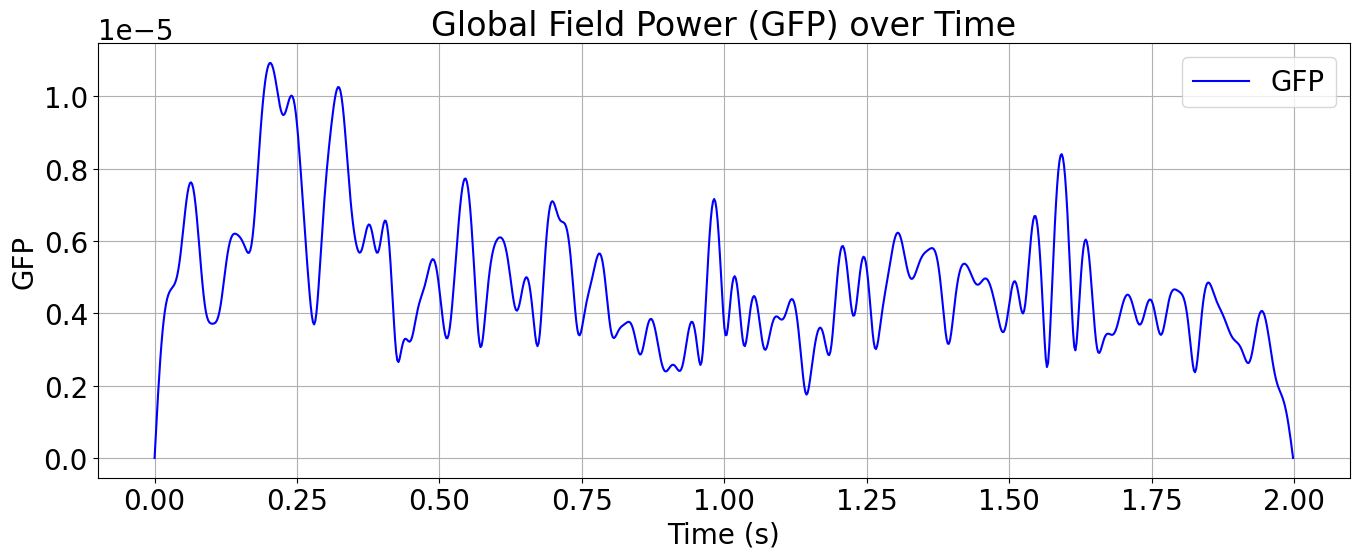

In [5]:
# Adjust the font size for all text elements
plt.rcParams.update({'font.size': 20})

# Plot the Global Field Power (GFP)
plt.figure(figsize=(14, 6))
plt.plot(eeg_data_filtered.times, gfp, color='blue', label='GFP')
plt.xlabel('Time (s)')
plt.ylabel('GFP')
plt.title('Global Field Power (GFP) over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Clustering
Group these potential microstates into clusters. We're looking to group them into 4 clusters corresponding to the predefined microstate classes A, B, C, and D.

We'll use the k-means clustering algorithm for this purpose. Once we've identified these 4 cluster centroids, we can visually inspect them to determine their correspondence to the predefined microstate classes.

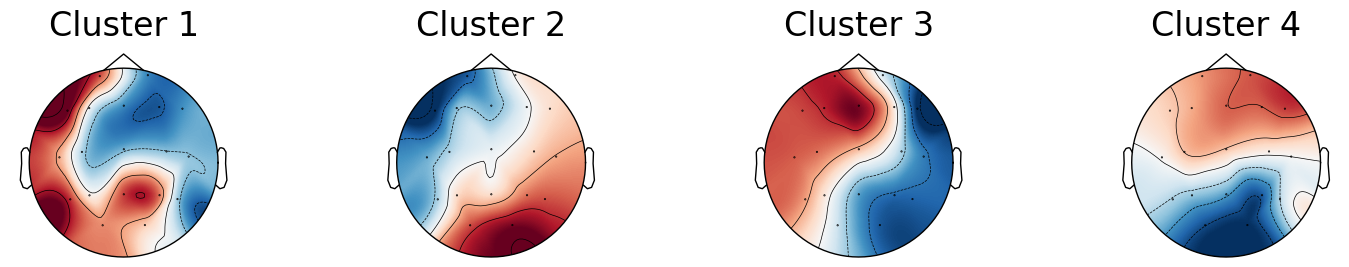

In [6]:
# Perform k-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(peak_topographies.T)

# Extract the cluster centroids (mean topographies for each cluster)
cluster_topographies = kmeans.cluster_centers_

# Set the "standard_1020" montage for the EEG data
montage = mne.channels.make_standard_montage('standard_1020')
eeg_data_filtered.set_montage(montage)

# Adjust the font size for all text elements
plt.rcParams.update({'font.size': 20})

# Plot the mean topographies for each cluster again
fig, axs = plt.subplots(1, n_clusters, figsize=(15, 3))
for i, ax in enumerate(axs):
    mne.viz.plot_topomap(cluster_topographies[i], eeg_data_filtered.info, axes=ax, show=False)
    ax.set_title(f'Cluster {i+1}')
plt.tight_layout()
plt.show()

# Assignment
Assign each microstate to one of the predefined classes based on similarity to the mean topography of each cluster.

In [7]:
# Assign each peak GFP time point to one of the clusters
labels = kmeans.predict(peak_topographies.T)

# Create a mapping based on the provided assignments
mapping = {0: 'A', 1: 'B', 3: 'C', 2: 'D'}
assigned_classes = [mapping[label] for label in labels]

assigned_classes


['C',
 'A',
 'A',
 'D',
 'B',
 'B',
 'C',
 'A',
 'A',
 'D',
 'A',
 'B',
 'D',
 'B',
 'A',
 'C',
 'C',
 'B',
 'D',
 'B',
 'C',
 'B',
 'C',
 'A',
 'B',
 'C',
 'A',
 'A',
 'C',
 'B',
 'C',
 'B',
 'C',
 'B',
 'C',
 'A',
 'A',
 'B',
 'C',
 'C']

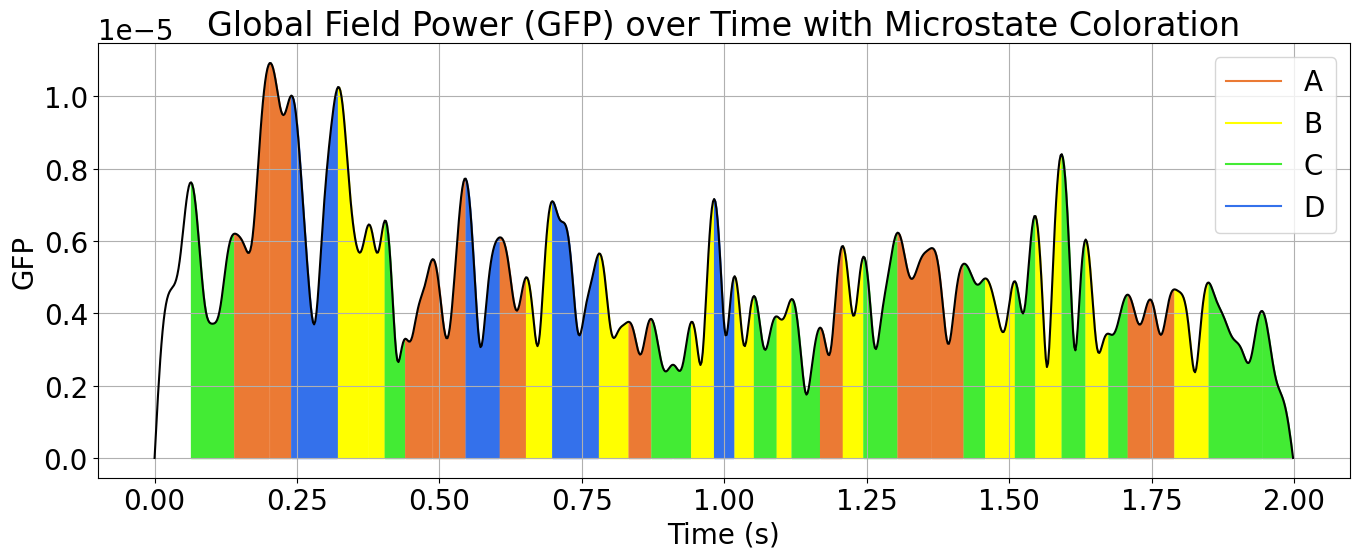

In [8]:
# Adjust the font size for all text elements
plt.rcParams.update({'font.size': 20})

# Define colors for each microstate class
color_map = {
    'A': '#eb7a34',
    'B': 'yellow',
    'C': '#43eb34',
    'D': '#3471eb' 
}
# Correctly plot the Global Field Power (GFP) with color coding for microstates
plt.figure(figsize=(14, 6))
for i, time in enumerate(peak_times):
    if i == len(peak_times) - 1:
        next_time = eeg_data_filtered.times[-1]
    else:
        next_time = peak_times[i + 1]
    times_slice = (eeg_data_filtered.times >= time) & (eeg_data_filtered.times < next_time)
    plt.fill_between(eeg_data_filtered.times[times_slice], 0, gfp[times_slice], color=color_map[assigned_classes[i]])

plt.plot(eeg_data_filtered.times, gfp, color='black', label='GFP')
plt.xlabel('Time (s)')
plt.ylabel('GFP')
plt.title('Global Field Power (GFP) over Time with Microstate Coloration')
handles = [plt.Line2D([0], [0], color=color_map[class_label], label=class_label) for class_label in ['A', 'B', 'C', 'D']]
plt.legend(handles=handles)
plt.grid(True)
plt.tight_layout()
plt.show()


# Metrics
1. **Average Duration or Lifespan**: This is the average time duration a microstate lasts.
2. **Frequency of Occurrence**: This is the number of times a microstate occurs divided by the total recording time.
3. **Coverage**: This is the fraction of total recording time that the microstate is dominant.
4. **Amplitude**: This is the average GFP during microstate dominance.
5. **Global Explained Varianc**e: This is the percentage of total variance explained by a given microstate.
6. **Transition Probabilities**: This is the probability of transitioning from one microstate to any other.

In [9]:
# Compute the average duration or lifespan for each microstate class
sampling_freq = eeg_data_filtered.info['sfreq']
durations = np.diff(peak_times, prepend=0)  # Time durations between successive peaks

# Calculate average duration for each class
average_durations = {}
for microstate_class in ['A', 'B', 'C', 'D']:
    durations_class = durations[np.array(assigned_classes) == microstate_class]
    average_durations[microstate_class] = np.mean(durations_class) if len(durations_class) > 0 else 0

average_durations # in seconds

{'A': 0.052545454545454534,
 'B': 0.04750000000000001,
 'C': 0.047230769230769236,
 'D': 0.0455}

In [10]:
# Compute the frequency of occurrence for each microstate class
total_time = eeg_data_filtered.times[-1]
frequency_of_occurrence = {}

for microstate_class in ['A', 'B', 'C', 'D']:
    count_class = sum(np.array(assigned_classes) == microstate_class)
    frequency_of_occurrence[microstate_class] = count_class / total_time

frequency_of_occurrence

{'A': 5.505505505505505,
 'B': 6.006006006006006,
 'C': 6.506506506506507,
 'D': 2.002002002002002}

In [11]:
# Compute the coverage for each microstate class
coverage = {}

for microstate_class in ['A', 'B', 'C', 'D']:
    durations_class = durations[np.array(assigned_classes) == microstate_class]
    coverage[microstate_class] = sum(durations_class) / total_time

coverage

{'A': 0.2892892892892892,
 'B': 0.2852852852852853,
 'C': 0.3073073073073074,
 'D': 0.09109109109109109}

In [12]:
# Correctly compute the amplitude (average GFP) for each microstate class
amplitude = {}

for microstate_class in ['A', 'B', 'C', 'D']:
    gfp_class = gfp[1:-1][peak_indices][np.array(assigned_classes) == microstate_class]
    amplitude[microstate_class] = np.mean(gfp_class) if len(gfp_class) > 0 else 0

amplitude

{'A': 5.4857346620798096e-06,
 'B': 5.693117492798647e-06,
 'C': 5.083266519798649e-06,
 'D': 8.005346887514641e-06}

In [13]:
# Correctly compute the global explained variance for each microstate class
global_variance = np.var(eeg_data_filtered._data)
explained_variance = {}
inverse_mapping = {v: k for k, v in mapping.items()}  # Invert the mapping for proper indexing

explained_variance = {}
for microstate_class in ['A', 'B', 'C', 'D']:
    topographies_class = peak_topographies[:, np.array(assigned_classes) == microstate_class]
    mean_topography = cluster_topographies[inverse_mapping[microstate_class]]
    variance_class = np.var(topographies_class - mean_topography[:, np.newaxis], ddof=1)
    explained_variance[microstate_class] = (global_variance - variance_class) / global_variance * 100

explained_variance

{'A': 30.483877136547143,
 'B': 28.79389538979006,
 'C': 39.00399757313737,
 'D': 24.37164385315286}

As a rule of thumb:

* Each microstate class should ideally have a GEV considerably higher than 25% (for a four-class model).
  
* The sum of the GEVs should be close to 100%.

In [14]:
# Compute the transition probabilities for each microstate class
transition_matrix = np.zeros((4, 4))

# Iterate over the assigned classes to count transitions
for i in range(1, len(assigned_classes)):
    prev_class = assigned_classes[i - 1]
    current_class = assigned_classes[i]
    transition_matrix[inverse_mapping[prev_class], inverse_mapping[current_class]] += 1

# Normalize the transition counts to get probabilities
transition_probabilities = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Convert to dictionary for readability
transition_probabilities_dict = {}
for i, microstate_class_i in enumerate(['A', 'B', 'C', 'D']):
    for j, microstate_class_j in enumerate(['A', 'B', 'C', 'D']):
        transition_probabilities_dict[f"{microstate_class_i} -> {microstate_class_j}"] = transition_probabilities[i, j]

transition_probabilities_dict


{'A -> A': 0.36363636363636365,
 'A -> B': 0.2727272727272727,
 'A -> C': 0.18181818181818182,
 'A -> D': 0.18181818181818182,
 'B -> A': 0.08333333333333333,
 'B -> B': 0.08333333333333333,
 'B -> C': 0.16666666666666666,
 'B -> D': 0.6666666666666666,
 'C -> A': 0.25,
 'C -> B': 0.75,
 'C -> C': 0.0,
 'C -> D': 0.0,
 'D -> A': 0.4166666666666667,
 'D -> B': 0.4166666666666667,
 'D -> C': 0.0,
 'D -> D': 0.16666666666666666}

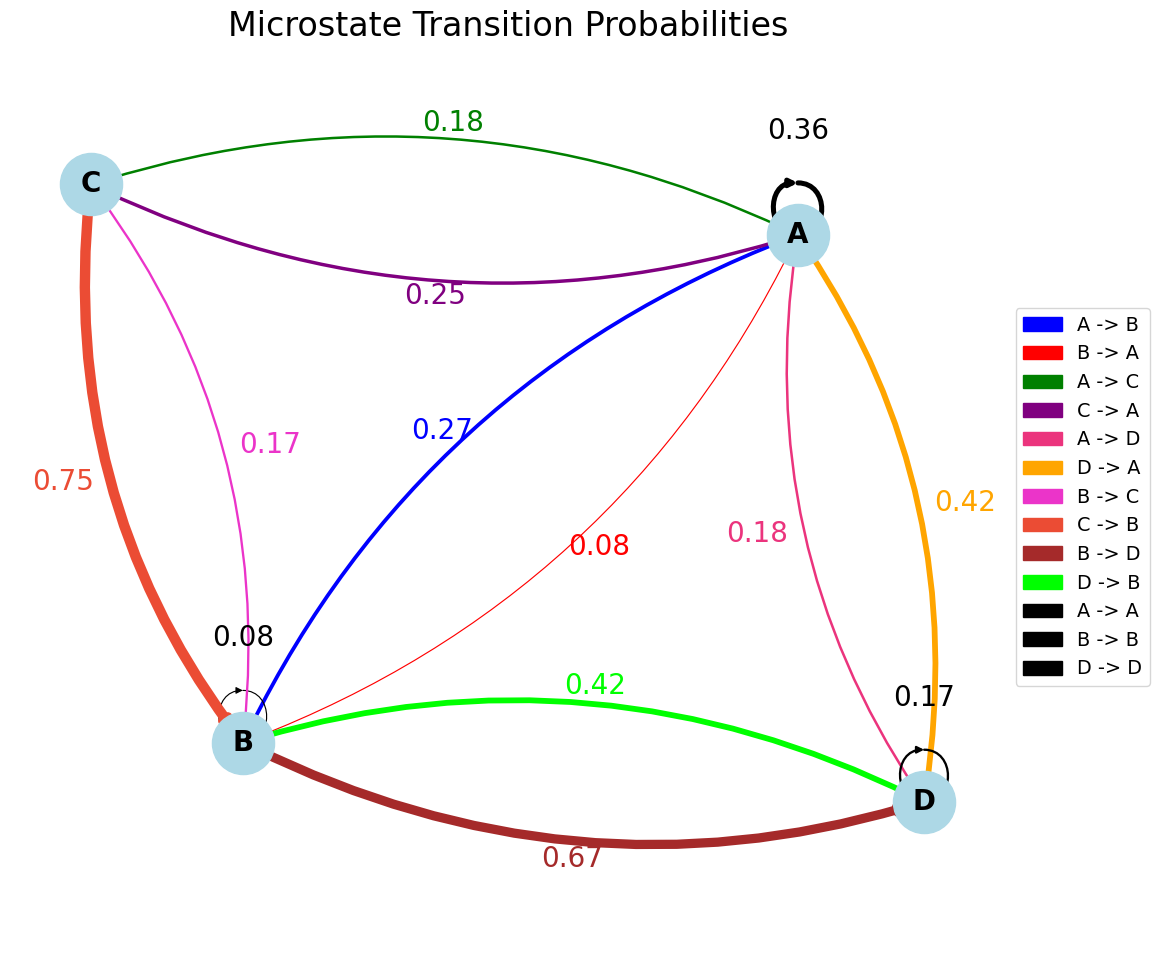

In [15]:
# Adjust the font size for all text elements
plt.rcParams.update({'font.size': 20})

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph based on transition probabilities
for transition, probability in transition_probabilities_dict.items():
    source, target = transition.split(' -> ')
    if probability > 0:  # Only add edges with non-zero probabilities
        G.add_edge(source, target, weight=probability)

# Define edge colors based on transitions
edge_colors = {
    'A -> B': 'blue',
    'B -> A': 'red',
    'A -> C': 'green',
    'C -> A': 'purple',
    'A -> D': '#eb347d',
    'D -> A': 'orange',
    'B -> C': '#eb34c9',
    'C -> B': '#eb4c34',
    'B -> D': 'brown',
    'D -> B': 'lime',
    'C -> D': 'gray',
    'D -> C': 'olive',
    'A -> A': 'black',
    'B -> B': 'black',
    'C -> C': 'black',
    'D -> D': 'black'
}

# Draw the graph
pos = nx.spring_layout(G)

# Function to adjust the annotation position to avoid overlap
def adjust_position(pos_source, pos_target, offset=0.2):
    delta_x = pos_target[0] - pos_source[0]
    delta_y = pos_target[1] - pos_source[1]
    
    # Calculate normalized direction vector for the edge
    length = (delta_x**2 + delta_y**2)**0.5
    direction = (delta_x/length, delta_y/length)
    
    # Adjust the position by the offset value
    x = (pos_source[0] + pos_target[0]) / 2 + direction[1] * offset
    y = (pos_source[1] + pos_target[1]) / 2 - direction[0] * offset
    
    return x, y

# Function to adjust the annotation position for self-looping arrows
def adjust_self_loop_position(pos_node, offset=0.3):
    return pos_node[0], pos_node[1] + offset

# Draw the graph with adjusted annotated transition probabilities for self-looping arrows
fig, ax = plt.subplots(figsize=(12, 10))

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, ax=ax, font_size=20, font_weight='bold')

# Draw the edges with annotated probabilities
for edge in G.edges(data=True):
    source, target = edge[0], edge[1]
    weight = edge[2]['weight']
    color = edge_colors[f"{source} -> {target}"]
    
    # Determine the curvature of the edge based on transition direction
    if source < target:
        curve = 0.2  # Curve the edge for one direction (e.g., A -> B)
    else:
        curve = 0.2  # Use a negative curve for the opposite direction (e.g., B -> A)
    
    # Draw the edge with curvature
    nx.draw_networkx_edges(G, pos, edgelist=[(source, target)], ax=ax, edge_color=color, width=weight * 10, connectionstyle=f'arc3,rad={curve}')
    
    # Adjust the position for the annotation
    if source == target:  # Handle self-looping arrows
        x, y = adjust_self_loop_position(pos[source])
    else:
        x, y = adjust_position(pos[source], pos[target], offset=0.25)
    
    # Annotate the edge with the probability value
    ax.text(x, y, f"{weight:.2f}", fontsize=20, verticalalignment='center', horizontalalignment='center', color=color)

# Legend positioned to the right of the plot
legend_handles = [mpatches.Patch(color=color, label=f'{transition}') for transition, color in edge_colors.items() if G.has_edge(transition.split(' -> ')[0], transition.split(' -> ')[1])]
ax.legend(handles=legend_handles, loc='center left', fontsize='x-small', bbox_to_anchor=(1, 0.5))

plt.title("Microstate Transition Probabilities")
plt.axis('off')
plt.tight_layout()
plt.show()
